In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
import os

In [2]:
#metrics setting
g_loss_metrics = tf.metrics.Mean(name='g_loss')
d_loss_metrics = tf.metrics.Mean(name='d_loss')
total_loss_metrics = tf.metrics.Mean(name='total_loss')

In [3]:
#hyper_parameters
ITERATION = 1000
Z_DIM = 100
BATCH_SIZE = 512
BUFFER_SIZE = 60000
G_LR = 0.0004
D_LR = 0.0004
GP_WEIGHT = 10.0
IMAGE_SHAPE = (28,28,1)
RANDOM_SEED = 42

In [4]:
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [5]:
test_z = tf.random.normal([16,Z_DIM])

In [6]:
def get_random_z(batch_size,z_dim):
    return tf.random.uniform([batch_size,z_dim],minval=-1,maxval=1)

In [7]:
#define discriminator
def make_discriminator(input_shape):
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(64,5,strides=2,padding='same',
                           input_shape=input_shape))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128,5,strides=2,padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model

In [8]:
D = make_discriminator(IMAGE_SHAPE)
D.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0

In [9]:
#define generator
def make_generator(input_shape):
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(7*7*256,use_bias=False,input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((7,7,256)))
    
    model.add(layers.Conv2DTranspose(128,5,strides=1,padding='same',
                                     use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64,5,strides=2,padding='same',
                                     use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(1,5,strides=2,padding='same'
                                     ,use_bias=False,activation='tanh'))
    return model

In [10]:
G = make_generator((Z_DIM,))
G.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 128)        

In [11]:
#Wasserstein Loss
def get_loss_fn():
    
    def d_loss_fn(real_logits,fake_logits):
        return tf.reduce_mean(fake_logits) - tf.reduce_mean(real_logits)
    
    def g_loss_fn(fake_logits):
        return -tf.reduce_mean(fake_logits)
    
    return d_loss_fn,g_loss_fn

In [12]:
#Gradinet Penalty(GP)
def gradient_penalty(generator,real_images):
    real_images = tf.cast(real_images,tf.float32)
    def _interpolate(a):
        beta = tf.random.uniform(tf.shape(a),0.,1.)
        b = a + 0.5 * tf.math.reduce_std(a)*beta
        shape=[tf.shape(a)[0]] + [1] * (a.shape.ndims -1)
        alpha = tf.random.uniform(shape,0.,1.)
        inter = a + alpha * (b - a)
        inter.set_shape(a.shape)
        return inter
    
    x = _interpolate(real_images)
    with tf.GradientTape() as tape:
        tape.watch(x)
        predictions = generator(x,training=True)
    grad = tape.gradient(predictions,x)
    slopes = tf.norm(tf.reshape(grad,[tf.shape(grad)[0],-1]),axis=1 )#tf.norm计算L1范数
    return tf.reduce_mean((slopes -1.) **2)

In [13]:
#data load & preprocessing
(train_x,_),(_,_) = tf.keras.datasets.fashion_mnist.load_data()
train_x = train_x[...,tf.newaxis].astype("float32")
train_x = (train_x - 127.5)/127.5 # 归一化到[-1,1]
train_ds = (
    tf.data.Dataset.from_tensor_slices(train_x)
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE,drop_remainder=True)
    .repeat()
)

In [14]:
#optimizer
g_optim = tf.keras.optimizers.Adam(G_LR,beta_1 = 0.5,beta_2 = 0.999)
d_optim = tf.keras.optimizers.Adam(D_LR,beta_1 = 0.5,beta_2 = 0.999)

In [15]:
#loss function
d_loss_fn,g_loss_fn = get_loss_fn()

In [16]:
def test_result():
    out = G(test_z)

    fig = plt.figure(figsize=(4,4))
    for idx in range(out.shape[0]):
        plt.subplot(4,4,idx+1)
        plt.imshow(out[idx]*127.5 + 127.5,cmap='gray')
        plt.axis('off')
    plt.show()

In [17]:
#@tf.function
def train_step(real_images):
    z = get_random_z(BATCH_SIZE,Z_DIM)
    with tf.GradientTape() as d_tape,tf.GradientTape() as g_tape:
        fake_images = G(z,training=True)
        
        fake_logits = D(fake_images,training = True)
        real_logits = D(real_images,training = True)
        
        d_loss = d_loss_fn(real_logits,fake_logits)
        g_loss = g_loss_fn(fake_logits)
        
        gp = gradient_penalty(partial(D,training = True),real_images)
        d_loss += gp*GP_WEIGHT 
        
    d_gradients = d_tape.gradient(d_loss,D.trainable_variables)
    g_gradients = g_tape.gradient(g_loss,G.trainable_variables)
    
    d_optim.apply_gradients(zip(d_gradients,D.trainable_variables))
    g_optim.apply_gradients(zip(g_gradients,G.trainable_variables))
    return g_loss,d_loss

In [18]:
#training loop
def train(ds,log_freq=50):
    ds = iter(ds)
    for step in range(ITERATION):
        images = next(ds)
        g_loss,d_loss = train_step(images)
        
        g_loss_metrics(g_loss)
        d_loss_metrics(d_loss)
        total_loss_metrics(g_loss + d_loss)
        
        if step % log_freq == 0:
            template = '[{}/{}] D_loss={:.5f} G_loss={:.5f} Total_loss={:.5f}'
            print(template.format(step,ITERATION,d_loss_metrics.result(),
                                 g_loss_metrics.result(),
                                 total_loss_metrics.result()))
            g_loss_metrics.reset_states()
            d_loss_metrics.reset_states()
            total_loss_metrics.reset_states()
            test_result()

[0/1000] D_loss=7.48816 G_loss=-0.03023 Total_loss=7.45792


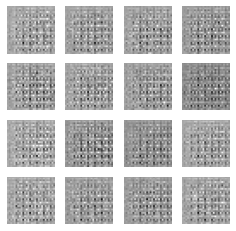

[50/1000] D_loss=3.40872 G_loss=-8.08516 Total_loss=-4.67644


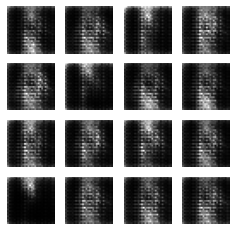

[100/1000] D_loss=1.52759 G_loss=-8.24219 Total_loss=-6.71460


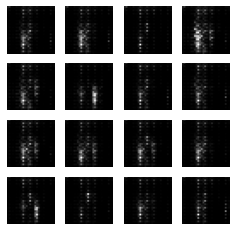

[150/1000] D_loss=0.58038 G_loss=-5.25650 Total_loss=-4.67612


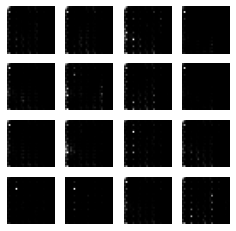

[200/1000] D_loss=0.56622 G_loss=-4.26600 Total_loss=-3.69978


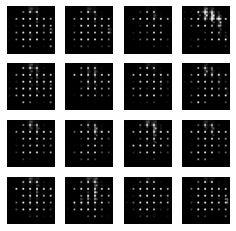

[250/1000] D_loss=0.51167 G_loss=-2.91015 Total_loss=-2.39848


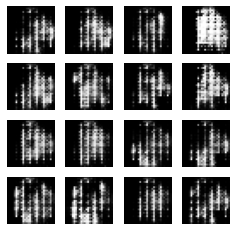

[300/1000] D_loss=0.27475 G_loss=-3.61873 Total_loss=-3.34398


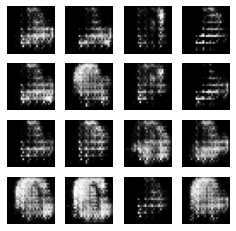

[350/1000] D_loss=-0.00498 G_loss=-3.67274 Total_loss=-3.67772


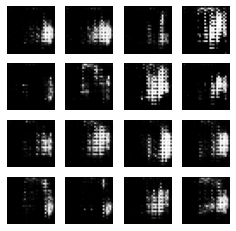

[400/1000] D_loss=-0.08260 G_loss=-3.95403 Total_loss=-4.03663


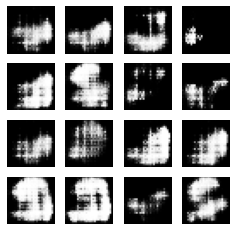

[450/1000] D_loss=-0.08608 G_loss=-3.79405 Total_loss=-3.88013


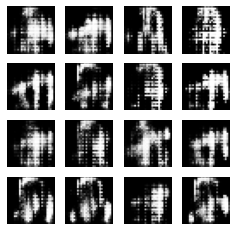

[500/1000] D_loss=-1.00999 G_loss=-2.97797 Total_loss=-3.98795


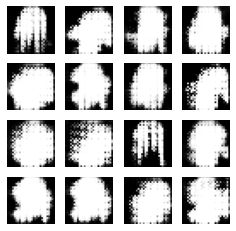

[550/1000] D_loss=-0.18648 G_loss=-2.78317 Total_loss=-2.96965


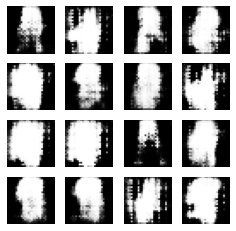

[600/1000] D_loss=0.09186 G_loss=-0.19727 Total_loss=-0.10541


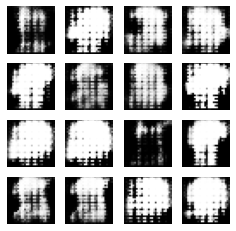

[650/1000] D_loss=0.72353 G_loss=-3.67697 Total_loss=-2.95344


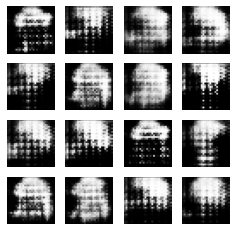

[700/1000] D_loss=-0.62234 G_loss=-1.91428 Total_loss=-2.53663


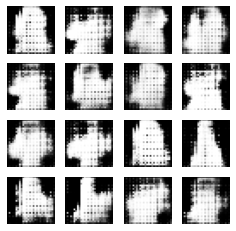

[750/1000] D_loss=-0.85571 G_loss=-4.09271 Total_loss=-4.94841


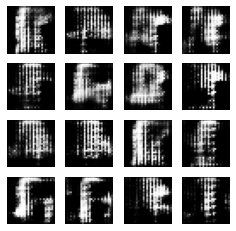

[800/1000] D_loss=-0.74691 G_loss=-1.78715 Total_loss=-2.53406


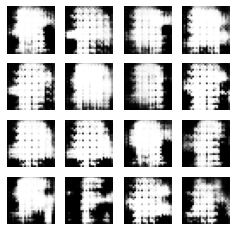

[850/1000] D_loss=-0.70594 G_loss=-1.38550 Total_loss=-2.09144


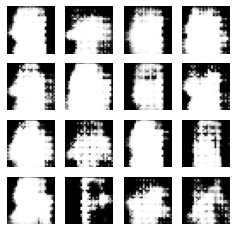

[900/1000] D_loss=-1.56613 G_loss=-1.15202 Total_loss=-2.71815


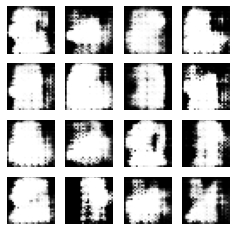

[950/1000] D_loss=-0.45922 G_loss=-1.66919 Total_loss=-2.12841


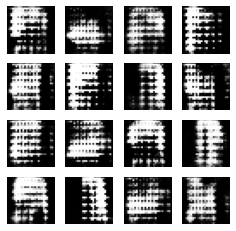

In [19]:
train(train_ds)